<a href="https://colab.research.google.com/github/ServAlex/ArduinoPlayground/blob/master/vae_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.layers import Input, Dense, Lambda, Dropout
from keras.models import Model
from keras.datasets import mnist
from keras import objectives
from keras import backend as K
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
#matplotlib inline
import numpy as np
from scipy.stats import norm
from keras.callbacks import EarlyStopping

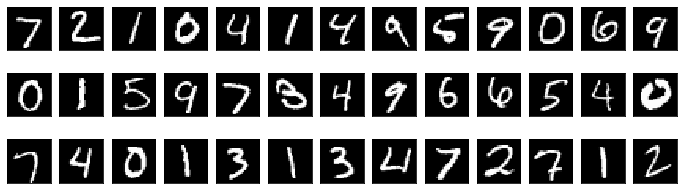

In [25]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
plt.figure(figsize=(12,12))
for i in range(39):
    ax = plt.subplot(10, 13, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [26]:
x_train = x_train.astype("float32") / 255 
x_test = x_test.astype("float32") / 255 
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))) 
x_test = x_test.reshape((len(x_test), np.prod(x_train.shape[1:])))

print('x train shape', x_train.shape) 
print('x test shape', x_test.shape)

n_hidden = 128 
z_dim = 2 
batch_size_count = 250 
epochs_count = 100 
beta = 1.5 
is_training = True

layer_name_mu = 'layer_mu' 
layer_name_log_var = 'layer_log_var'

img_dim = x_train.shape[1]

print('image dim') 
print(img_dim)

x train shape (60000, 784)
x test shape (10000, 784)
image dim
784


In [27]:
input_img = Input(shape=(img_dim,))
print('input image shape')
print(input_img.shape)

#encoder
encoded = Dense(n_hidden, activation='relu')(input_img)
print('encoder stage 1 shape')
print(encoded.shape)
encoded = Dropout(0.3)(encoded)

encoded = Dense(n_hidden//2, activation='relu')(encoded)
print('encoder stage 2 shape')
print(encoded.shape)
encoded = Dropout(0.2)(encoded)


encoded = Dense(n_hidden//4, activation='relu')(encoded)
print('encoder stage 3 shape')
print(encoded.shape)
#encoded = Dropout(0.1)(encoded)

mu = Dense(z_dim, name = layer_name_mu)(encoded)
print('mu shape')
print(mu.shape)
#mu.name = layer_name_mu

log_var = Dense(z_dim, name = layer_name_log_var)(encoded)
print('log_var shape')
print(log_var.shape)
#log_var.name = layer_name_log_var


input image shape
(?, 784)
encoder stage 1 shape
(?, 128)
encoder stage 2 shape
(?, 64)
encoder stage 3 shape
(?, 32)
mu shape
(?, 2)
log_var shape
(?, 2)


In [28]:
def sampling(args):
    mu, log_var = args
    eps = tf.random.normal(shape=(batch_size_count, z_dim), mean=0., stddev=1.0)
    print('eps shape\t', eps.shape)
    print('mu shape\t', mu.shape)
    print('log_var shape\t', log_var.shape)
    return mu + K.exp(log_var) * eps

z = Lambda(sampling, output_shape=(z_dim,))([mu, log_var])
print('z shape \t', z.shape)

eps shape	 (250, 2)
mu shape	 (?, 2)
log_var shape	 (?, 2)
z shape 	 (250, 2)


In [29]:
# decoder
z_decoder1 = Dense(n_hidden//4, activation='relu')
z_decoder2 = Dense(n_hidden//2, activation='relu')
z_decoder3 = Dense(n_hidden, activation='relu')
y_decoder = Dense(img_dim, activation='sigmoid')

z_decoded = z_decoder1(z)
#z_decoded = Dropout(0.1)(z_decoded)
print('decoded stage 1 shape \t', z_decoded.shape)

z_decoded = z_decoder2(z_decoded)
z_decoded = Dropout(0.2)(z_decoded)
print('decoded stage 2 shape \t', z_decoded.shape)

z_decoded = z_decoder3(z_decoded)
z_decoded = Dropout(0.3)(z_decoded)
print('decoded stage 3 shape \t', z_decoded.shape)

y = y_decoder(z_decoded)
print('y shape \t', y.shape)


decoded stage 1 shape 	 (250, 32)
decoded stage 2 shape 	 (250, 64)
decoded stage 3 shape 	 (250, 128)
y shape 	 (250, 784)


In [30]:
# loss
reconstruction_loss = objectives.binary_crossentropy(input_img, y) * img_dim
kl_loss = K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
vae_loss = reconstruction_loss + beta*kl_loss

# build model
vae = Model(input_img, y)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')   #'Adadelta', 'rmsprop''Adagrad'
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 128)          100480      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 128)          0           dense_8[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 64)           8256        dropout_7[0][0]                  
__________________________________________________________________________________________________
dropout_8 

In [31]:

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# fitting
history = vae.fit(x_train,
       shuffle=True,
       epochs=epochs_count,
       batch_size=batch_size_count,
       validation_data=(x_test, None), 
       verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 2s 31us/step - loss: 223.5395 - val_loss: 196.6903
Epoch 2/100
60000/60000 [==============================] - 1s 21us/step - loss: 196.9665 - val_loss: 194.7406
Epoch 3/100
60000/60000 [==============================] - 1s 22us/step - loss: 195.0219 - val_loss: 193.5164
Epoch 4/100
60000/60000 [==============================] - 1s 22us/step - loss: 194.2843 - val_loss: 192.8171
Epoch 5/100
60000/60000 [==============================] - 1s 22us/step - loss: 193.8181 - val_loss: 193.4611
Epoch 6/100
60000/60000 [==============================] - 1s 22us/step - loss: 193.4535 - val_loss: 193.0822
Epoch 7/100
60000/60000 [==============================] - 1s 21us/step - loss: 193.1555 - val_loss: 191.9043
Epoch 8/100
60000/60000 [==============================] - 1s 22us/step - loss: 192.8191 - val_loss: 192.2634
Epoch 9/100
60000/60000 [==============================] - 1s 22us/ste

In [0]:
intermediate_layer_model_mu = Model(inputs=vae.input, outputs=vae.get_layer(layer_name_mu).output)
intermediate_output_mu = intermediate_layer_model_mu.predict(x_test)

intermediate_layer_model_var_log = Model(inputs=vae.input, outputs=vae.get_layer(layer_name_log_var).output)
intermediate_output_var_log = intermediate_layer_model_var_log.predict(x_test)


In [33]:
intermediate_output_mu

array([[ 1.0079466 ,  0.24355318],
       [-0.40875593,  0.08846496],
       [-1.0519527 , -1.1128219 ],
       ...,
       [ 1.0499907 ,  0.10146655],
       [ 0.5094926 , -0.758679  ],
       [-0.8558444 ,  0.61265296]], dtype=float32)

(10000, 784)


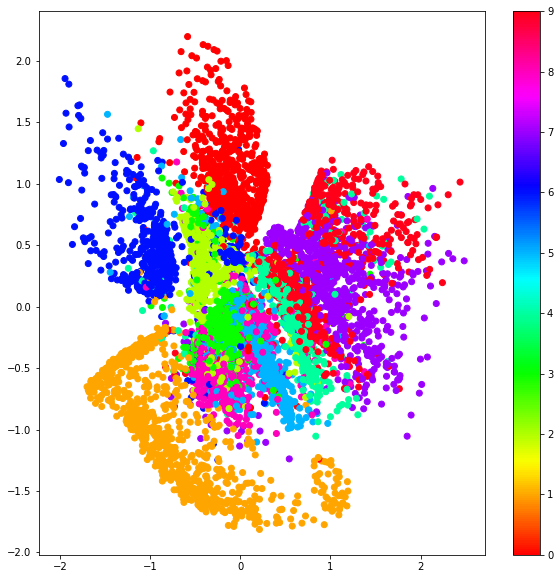

In [34]:
print(x_test.shape)

x_test_latent = intermediate_output_mu
plt.figure(figsize=(10, 10))
plt.hsv()
plt.scatter(x_test_latent[:, 0], x_test_latent[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [0]:
x_test_latent = intermediate_output_var_log

(10000, 784)


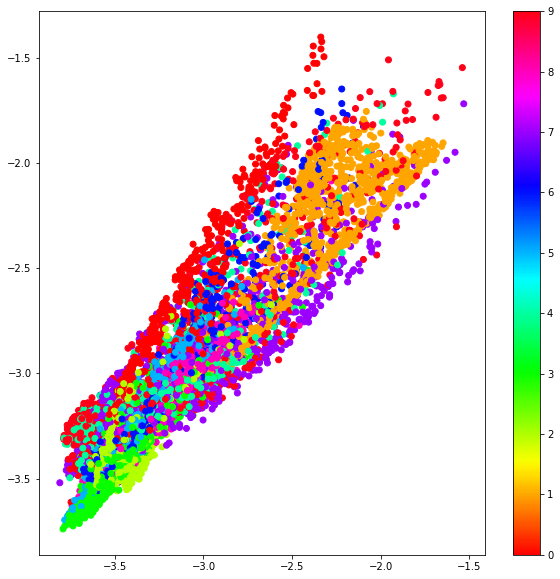

In [36]:
print(x_test.shape)

x_test_latent = intermediate_output_var_log
plt.figure(figsize=(10, 10))
plt.hsv()
plt.scatter(x_test_latent[:, 0], x_test_latent[:, 1], c=y_test)
plt.colorbar()
plt.show()

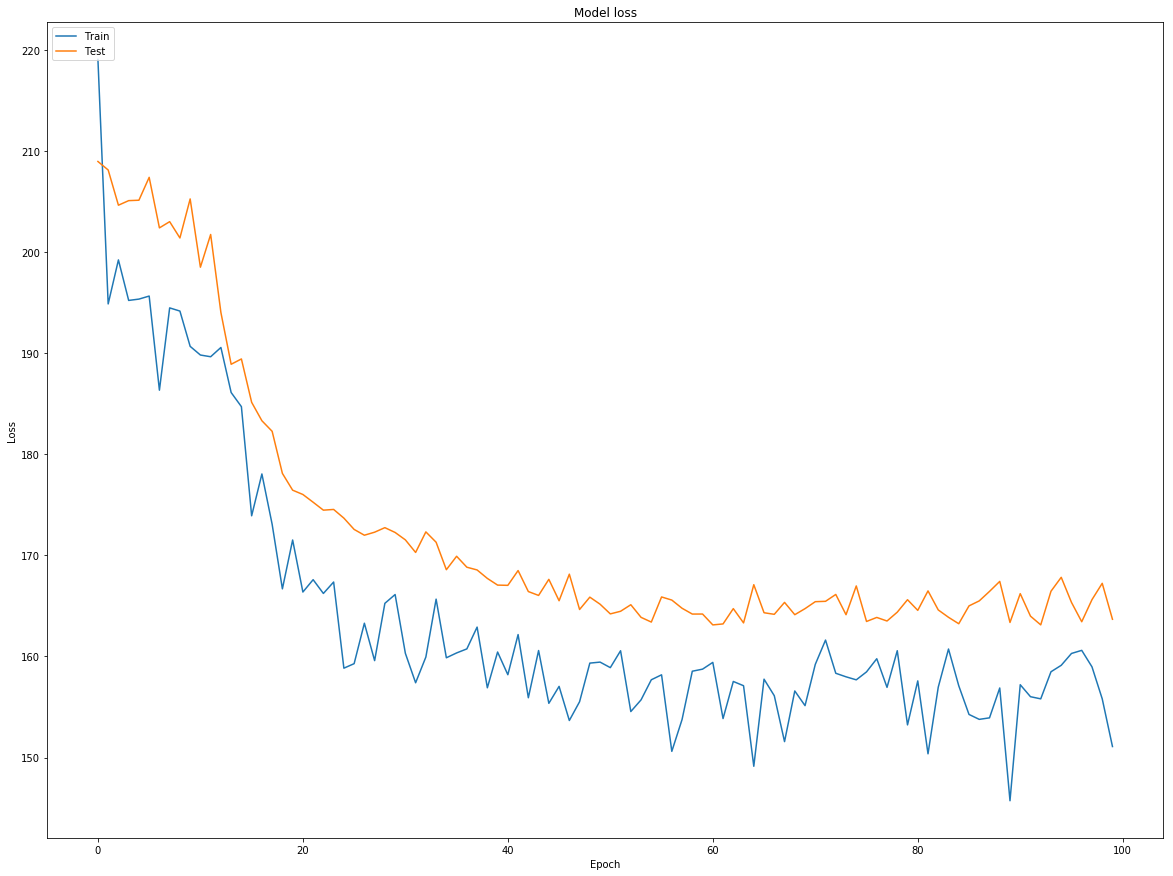

In [37]:
# Plot training & validation loss values
plt.figure(figsize=(20, 15))
plt.plot([a[1] for a in history.history['loss']])
plt.plot([a[1] for a in history.history['val_loss']])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [38]:
print(np.shape(history.history['loss']))
print(type(history.history['loss'][1]))

(100, 250)
<class 'numpy.ndarray'>


In [39]:
decoder_input = Input(shape=(z_dim,))
_z_decoded = z_decoder1(decoder_input)
_z_decoded = z_decoder2(_z_decoded)
_z_decoded = z_decoder3(_z_decoded)
_y = y_decoder(_z_decoded)
generator = Model(decoder_input, _y)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_12 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_13 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_14 (Dense)             (None, 784)               101136    
Total params: 111,664
Trainable params: 111,664
Non-trainable params: 0
_________________________________________________________________


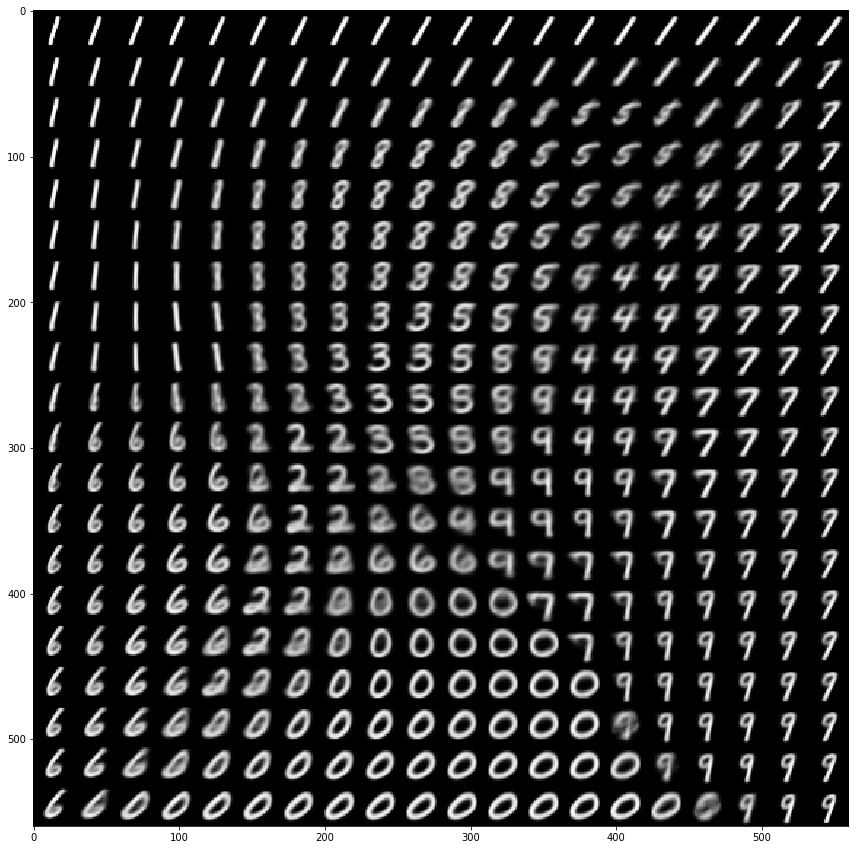

In [40]:
n = 20 # figure with 15x15 digits
digit_size = 28

figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.01, 0.99, n)) 
grid_y = norm.ppf(np.linspace(0.01, 0.99, n))

plt.figure(figsize=(15,15))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([xi, yi])
        z_sample = np.expand_dims(z_sample, axis = 0)

        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)

        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
plt.imshow(figure,  cmap='Greys_r')